In [1]:
!pip install natsort pyedflib mne

  Using cached natsort-8.4.0-py3-none-any.whl (38 kB)


In [2]:
!which python

/home/madhav/anaconda3/envs/kedalion_py39/bin/python


In [1]:
import urllib.request
import numpy as np
import pyedflib
import glob
import os
import re
import numpy as np
from scipy import signal
from mne.preprocessing import ICA
from scipy.stats import zscore
import matplotlib.pyplot as plt
from natsort import natsorted

In [2]:
root_dir = os.path.abspath('/')
data_dir = root_dir+'/home/madhav/Desktop/bci/Datasets/eeg-motor-movementimagery-dataset-1.0.0/files/'

In [4]:
#dir = os.getcwd()
fpaths = data_dir + '/*/*.edf'                                                                     
files = natsorted(glob.glob(fpaths))
#basefile_re_pattern = r".*0[12]\.edf$"

target_channels = ['Fz', 'C3', 'Cz', 'C4', 'Pz', 'Po7', 'Oz', 'Po8']
#target_channels = []
sampling_rate = 160

epochs = []          
states = []                                       
#States for Brain Pattern Analysis - i)default mode state, ii)active response state (motor movement)
#event_markers = []

In [5]:
for file in files:
    #print(file)
    
    if re.search(r".*0[12]\.edf$", file):
        continue                                                                                        #baseline files of the subject. Evaluate for later, skip
        
    f = pyedflib.EdfReader(file)
    
    rec_channels = list(map(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x), f.getSignalLabels()))           #recorded channels, cleaned labels    
        
    if not target_channels:
        channels = {channel:i for i, channel in enumerate(rec_channels)}
    else:
        channels = {channel:i for i, channel in enumerate(rec_channels) if channel in target_channels}  #extract only 8-channel info based on Unicorn Hybrid Black EEG
    
    annotations = f.readAnnotations()                                                                   #Annotations for the MI EEG data
    event_times = annotations[0]                                                                        #event start points in the trial - event is change to rest state or responding to movement/imagined movement cue
    state_durations = annotations[1]                                                                    #state duration OR time until the next start point 
    state_labels = annotations[2]                                                                       #event/action specified in https://physionet.org/content/eegmmidb/1.0.0/
    
    cut_off = 0.1                                                                                      #cut-off to extract epochs, limited cut-off
    #trial_data = np.zeros((f.signals_in_file,max(f.getNSamples())))   #(64,20000)
    trial_data = np.zeros((len(channels),max(f.getNSamples())))  #(8,20000)
    
    for i, ch_idx in enumerate(channels.values()):
        trial_data[i,:] = f.readSignal(ch_idx)
        
    for i in range(0,len(event_times)):                                                                #sampling every state (rest or movement/imagined movement). 
        
        start_index = int((event_times[i] + cut_off) * sampling_rate)                                   #start at rest-state event times, add cut-off to allow for neural reset
        end_index = int((event_times[i] + state_durations[i] - cut_off) * sampling_rate)                #sample for uptill a second (cut-off) before state changes.
    
        epoch = trial_data[:, start_index:end_index]                                                    # Assuming trial_data has shape (channels, time)
        epochs.append(epoch)                                                                            # Extarct epoch segment from the trial

        
        
        # Extact the label relavant to the action performed as described in https://physionet.org/content/eegmmidb/1.0.0/
        
        if re.search(r".*0[37]\.edf$",file) or re.search(r".*11.edf$",file):                            #moved left hand L(T1) or right hand R(T2)
            if state_labels[i] == 'T1':
                states.append('L')
            elif state_labels[i] == 'T2':
                states.append('R')
            else: 
                states.append('Rest')
       
        if re.search(r".*0[48]\.edf$",file) or re.search(r".*12.edf$",file):                            #imagined left hand IL(T1) or imagined right hand IR(T2)
            if state_labels[i] == 'T1':
                states.append('IL')
            elif state_labels[i] == 'T2':
                states.append('IR')
            else: 
                states.append('Rest')
            
        if re.search(r".*0[59]\.edf$",file) or re.search(r".*13.edf$",file):                            #moved both fists B(T1) or both feet F(T2)
            if state_labels[i] == 'T1':
                states.append('B')
            elif state_labels[i] == 'T2':
                states.append('F')
            else: 
                states.append('Rest')
   
        if re.search(r".*1[04]\.edf$",file) or re.search(r".*06.edf$",file):                            #imagined both fists IB(T1) or both feet IF(T2)
            if state_labels[i] == 'T1':
                states.append('IB')
            elif state_labels[i] == 'T2':
                states.append('IF')
            else:
                states.append('Rest')
                
    f.close()

In [7]:
print(channels.keys())
print(len(epochs))
print(len(states))

dict_keys(['C3', 'Cz', 'C4', 'Fz', 'Pz', 'Po7', 'Po8', 'Oz'])
39349
39349


In [8]:
filtered_epochs = []
filtered_states = []

for epoch, state in zip(epochs, states):                                                                #filter all epochs (and corresponding states) less than 300 samples and greater than 400 samples
    if 300 <= epoch.shape[1] <= 400:
        filtered_epochs.append(epoch)
        filtered_states.append(state)

epochs = filtered_epochs
states = filtered_states                

In [ ]:

states_dict = {state:i for i,state in enumerate(sorted(set(states)))} 
print(states_dict)

In [11]:
print(len(epochs))

38147


In [55]:
max_length = 2.0                                                                                        # 2 secs or 320 samplesa

In [56]:
for i in range(len(epochs)):
    epochs[i] = epochs[i][:,:int(max_length*sampling_rate)]                                                #standardize all the epochs to same sample-size; truncate.

In [57]:
print(epochs[0].shape)

(8, 320)


In [58]:
class Preprocess:
    def __init__(self, sfreq, target_freq=100, ica_components=64, high_pass_cutoff=8, low_pass_cutoff=70, notch_freq=60):
        self.sfreq = sfreq
        self.ica_components = ica_components
        self.high_pass_cutoff = high_pass_cutoff
        self.low_pass_cutoff = low_pass_cutoff
        self.notch_freq = notch_freq
        self.target_freq = target_freq
        #self.target_channels = target_channels
        #self.available_channels = available_channels
        self.ica = None
        
    def resample_epoch(self, epoch_data):
        #original_sfreq = self.sfreq
        #target_sfreq = self.target_freq
        num_channels, num_samples = epoch_data.shape
        target_num_samples = int(num_samples * self.target_freq / self.sfreq)
        resampled_data = signal.resample(epoch_data, target_num_samples, axis=1)
        
        return resampled_data


    def high_pass_filtering(self, eeg_epoch):
        
        nyquist_freq = 0.5 * self.sfreq
        freq_cutoff = self.high_pass_cutoff / nyquist_freq
        b, a = signal.butter(4, freq_cutoff, btype='highpass')
        filtered_epoch = signal.filtfilt(b, a, eeg_epoch, axis=1)
        
        return filtered_epoch

    def low_pass_filtering(self, eeg_epoch):
        
        nyquist_freq = 0.5 * self.sfreq
        freq_cutoff = self.low_pass_cutoff / nyquist_freq
        b, a = signal.butter(4, freq_cutoff, btype='lowpass')
        filtered_data = signal.filtfilt(b, a, eeg_epoch, axis=1)
        
        return filtered_data

    def remove_notch_noise(self, eeg_epoch):
        
        nyquist_freq = 0.5 * self.sfreq
        notch_bandwidth = 1.0  # Width of the notch filter 
        notch_freq_norm = self.notch_freq / nyquist_freq
        b, a = signal.iirnotch(notch_freq_norm, notch_bandwidth)
        filtered_data = signal.filtfilt(b, a, eeg_epoch, axis=1)
        
        return filtered_data

    def apply_ica(self, eeg_epoch):
        
        if self.ica is None:
            self.ica = ICA(n_components=self.ica_components, random_state=0)
            self.ica.fit(eeg_epoch)
        cleaned_data = self.ica.apply(eeg_epoch)
        
        return cleaned_data

    def apply_average_reference_epoch(self, epoch_data):
        
        average_reference = np.mean(epoch_data, axis=0)
        referenced_epoch_data = epoch_data - average_reference
        
        return referenced_epoch_data
    
    def normalize_epoch(self,epoch_data):
        #Min-Max Scaler 
        min_val = np.min(epoch_data, axis=1, keepdims=True)
        max_val = np.max(epoch_data, axis=1, keepdims=True)
        normalized_data = (epoch_data - min_val) / (max_val - min_val)

        return normalized_data
        

In [59]:
#preprocess all the samples
target_frequency = 100
preprocess = Preprocess(sfreq=sampling_rate, ica_components=8, target_freq=target_frequency)
for i in range(len(epochs)):
    epochs[i] = preprocess.resample_epoch(epochs[i])
    epochs[i] = preprocess.low_pass_filtering(epochs[i])
    epochs[i] = preprocess.high_pass_filtering(epochs[i])
    epochs[i] = preprocess.remove_notch_noise(epochs[i])
    epochs[i] = preprocess.apply_average_reference_epoch(epochs[i])
    epochs[i] = preprocess.normalize_epoch(epochs[i])

In [60]:
print(epochs[0].shape)

(8, 200)


In [61]:
print(len(states))

38147


In [62]:
epochs = np.stack(epochs, axis=0)
print(epochs.shape)

(38147, 8, 200)


In [63]:
states_epochs = [[] for _ in range(len(states_dict))]

In [64]:
for epoch, state in zip(epochs, states):
    states_epochs[states_dict[state]].append(epoch)

In [65]:
for i in range(len(states_epochs)):
    states_epochs[i] = np.stack(states_epochs[i], axis=0)

In [66]:
print(len(states_epochs))

9


In [67]:
def extract_mean_variance_features_with_states(states_epochs):
    """
    Extracts mean and variance features from the epochs for each state.
    
    Args:
        state_epochs (list): List (n_states) of Epochs from each state (n_epochs, n_channels, n_samples_per_epoch).
        
    
    Returns:
        mean_features (numpy.ndarray): List (n_states) of Mean features for each state (n_epochs,n_channels).
        var_features (numpy.ndarray): List (n_states) of Var features for each state (n_epochs,n_channels).
    """
    mean_features = []
    var_features = []
    
    for state_epochs in states_epochs:
        state_mean_features = np.stack([np.mean(epoch, axis=1) for epoch in state_epochs])
        state_var_features = np.stack([np.var(epoch, axis=1) for epoch in state_epochs])
        
        mean_features.append(state_mean_features)
        var_features.append(state_var_features)
    
    return mean_features, var_features

In [68]:
mean_features, var_features = extract_mean_variance_features_with_states(states_epochs)

In [69]:
print(len(mean_features))

9


In [70]:
first_channel_means = [state_means[:, 0] for state_means in mean_features]

In [71]:
print(len(first_channel_means[0]))

2363


In [73]:
from matplotlib import cm
colours = cm.rainbow(np.linspace(0, 1, 8))
print(colours)

[[5.00000000e-01 0.00000000e+00 1.00000000e+00 1.00000000e+00]
 [2.17647059e-01 4.29120609e-01 9.75511968e-01 1.00000000e+00]
 [7.25490196e-02 7.82927610e-01 9.00586702e-01 1.00000000e+00]
 [3.54901961e-01 9.74138602e-01 7.82927610e-01 1.00000000e+00]
 [6.45098039e-01 9.74138602e-01 6.22112817e-01 1.00000000e+00]
 [9.27450980e-01 7.82927610e-01 4.34676422e-01 1.00000000e+00]
 [1.00000000e+00 4.29120609e-01 2.19946358e-01 1.00000000e+00]
 [1.00000000e+00 1.22464680e-16 6.12323400e-17 1.00000000e+00]]


In [78]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

palette = sns.color_palette("husl", 256)
rgb_palette = [tuple(int(color * 255) for color in rgb) for rgb in palette]

def plot_mean_vs_variance(mean_features, var_features, channel_index):

    
    for state_index in range(len(mean_features)):
        channel_means = [epoch_means[channel_index] for epoch_means in mean_features[state_index]]
        channel_variances = [epoch_variances[channel_index] for epoch_variances in var_features[state_index]]
        plt.scatter(channel_means, channel_variances, color=(256,0,0), cmap='rainbow')
        
    # Calculate the average mean and variance values
    #mean_avg = np.mean(channel_means)
    #variance_avg = np.mean(channel_variances)

    # Create a scatter plot of mean versus variance averages
    #plt.scatter(channel_means, channel_variances)
    #plt.axvline(x=mean_avg, color='r', linestyle='--', label='Average Mean')
    #plt.axhline(y=variance_avg, color='b', linestyle='--', label='Average Variance')
    plt.xlabel('Mean')
    plt.ylabel('Variance')
    plt.title('Mean vs Variance for Channel {}'.format(target_channels[channel_index]))
    plt.legend()
    plt.show()
    
    return channel_means, channel_variances

In [1]:
channel_index = 0
state_index = 0
channel_means, channel_variances = plot_mean_vs_variance(mean_features, var_features, channel_index)

NameError: name 'plot_mean_vs_variance' is not defined

In [68]:
def detect_change_points(eeg_epoch, sliding_window_size, threshold):
    num_channels, num_samples = eeg_epoch.shape
        epoch_change_points = []

    for channel in range(num_channels):
        channel_data = eeg_epoch[channel]
        z_scores = zscore(channel_data)

        channel_change_points = []

        for i in range(sliding_window_size, num_samples - sliding_window_size):
            mean_before = np.mean(channel_data[i - sliding_window_size:i])
            mean_after = np.mean(channel_data[i:i + sliding_window_size])
            std_before = np.std(channel_data[i - sliding_window_size:i])
            std_after = np.std(channel_data[i:i + sliding_window_size])

            if abs(mean_before - mean_after) > threshold or abs(std_before - std_after) > threshold:
                channel_change_points.append(i)

        epoch_change_points.append(channel_change_points)

    return epoch_change_points

IndentationError: unexpected indent (391816753.py, line 3)

In [31]:
for epoch in range(len(epochs)):
    epoch_change_points = detect_change_points(epochs[epoch],sliding_window_size=sliding_window_size,threshold=threshold)
    detected_change_points.append(epoch_change_points)

In [32]:
def plot_change_points(epoch, epoch_change_points, channel_labels=None, event_marker=None, event=None):
    num_channels, num_samples = epoch.shape

    fig, axs = plt.subplots(num_channels, 1, figsize=(15, 12))

    for channel in range(num_channels):
        axs[channel].plot(epoch[channel])

        channel_change_points = epoch_change_points[channel]
        axs[channel].scatter(channel_change_points, epoch[channel][channel_change_points], color='red', marker='o', label='Change Points')
        axs[channel].legend()

        if event_marker is not None:
            axs[channel].axvline(x=event_marker*target_frequency, linestyle='--', color='black', label='Event Marker')

            if event is not None:
                axs[channel].text(event_marker*target_frequency, axs[channel].get_ylim()[1], event, color='black', ha='center', va='bottom')

        if channel_labels is not None:
            axs[channel].set_ylabel(channel_labels[channel])

    plt.tight_layout()
    plt.show()


In [33]:
all_left = [(events[i],i) for i, event in enumerate(events) if events[i] == 'IL']
print(all_left)

[('IL', 16), ('IL', 17), ('IL', 20), ('IL', 22), ('IL', 24), ('IL', 25), ('IL', 27), ('IL', 29), ('IL', 75), ('IL', 77), ('IL', 79), ('IL', 81), ('IL', 84), ('IL', 85), ('IL', 88), ('IL', 89), ('IL', 136), ('IL', 138), ('IL', 139), ('IL', 142), ('IL', 143), ('IL', 146), ('IL', 148)]


In [34]:
print(detected_change_points[0][4])

[100, 101, 102, 179, 376, 377, 378, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 529, 530, 531, 532]


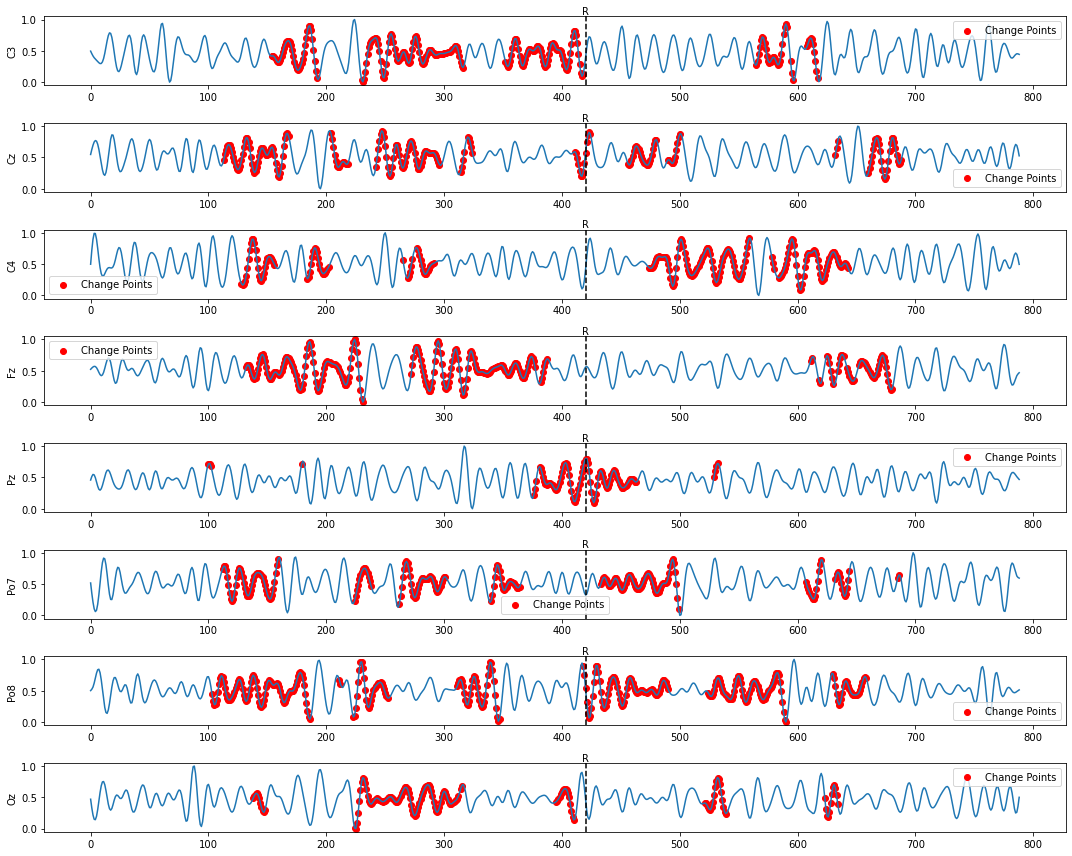

In [35]:

eval_epoch = 0
plot_change_points(epochs[eval_epoch], detected_change_points[eval_epoch], event_marker=event_markers[eval_epoch], channel_labels=list(channels.keys()), event=events[eval_epoch])

In [64]:
import numpy as np
from ruptures import Pelt
import matplotlib.pyplot as plt

num_channels, num_time_points = cp_epochs[0].shape
data = np.zeros((num_trials, num_channels, num_time_points))
print(data.shape)
print(num_trials,num_channels,num_time_points)

for i, trial in enumerate(cp_epochs):
    #print("here")
    data[i] = np.array(cp_epochs[i])

print(data)
#data = np.array(cp_epochs, dtype = object)

NameError: name 'cp_epochs' is not defined

(180, 8, 1263)
180 8 1263
[[[   4.    5.   11. ...   12.   26.   30.]
  [  40.   45.   51. ...  -10.   -1.   -4.]
  [  31.   26.   19. ...   23.   12.    2.]
  ...
  [  27.   31.   30. ...   43.   41.   55.]
  [  62.   45.   30. ...    0.  -27.    3.]
  [  46.   47.   42. ...   -9.  -16.  -10.]]

 [[   4.   -4.  -22. ...   42.  -10.  -28.]
  [   4.   -1.  -18. ...   89.   62.   10.]
  [ -27.  -10.  -20. ...   46.   23.   -2.]
  ...
  [ -20.  -29.  -42. ...  -23.  -29.   -6.]
  [ -31.  -22.  -29. ...  -13.  -21.  -38.]
  [ -25.  -25.  -23. ...    1.  -16.  -33.]]

 [[  18.   23.   15. ...   63.   78.   87.]
  [  61.   45.   22. ...   19.   43.   45.]
  [  24.   29.   18. ...   32.   44.   46.]
  ...
  [  50.   32.   35. ...   79.  118.  117.]
  [  62.   37.   36. ...   58.   65.   58.]
  [  50.   33.    5. ...   49.   93.   99.]]

 ...

 [[ -60.  -89.  -87. ...   67.   56.   26.]
  [ -24.  -68.  -80. ...   63.   48.   27.]
  [ -13.  -61.  -70. ...   81.   67.   61.]
  ...
  [ -93. -110.

In [35]:
#data = np.zeros((num_trials,num_channels,num_time_points))

# Reshape the EEG data for PELT input (shape: (num_samples, num_features))
data = np.reshape(data,(num_trials * num_channels, num_time_points))
print(data.shape)
# Perform change point detection using PELT
model = Pelt().fit(data)
result = model.predict(pen=1)


# Reshape the change point results back to per-trial format
change_points = np.reshape(result,(num_trials, -1))


# Plot the change points for each trial
for trial_idx, cp in enumerate(change_points):
    plt.plot(cp, np.ones_like(cp) * trial_idx, 'ro')
plt.xlabel('Time Points')
plt.ylabel('Trial Index')
plt.title('Change Points Detected by PELT')
plt.show()

(1440, 1263)


ValueError: cannot reshape array of size 288 into shape (180,newaxis)

In [28]:
a = np.array([[1, 2, 3, 4], [3, 4, 5, 6], [4, 5, 6, 7]])

In [29]:
print(a.shape)

(3, 4)


In [30]:
aa = np.mean(a, axis=1)

In [31]:
print(aa)

[2.5 4.5 5.5]
